# Sistemas de Recomendación - Netflix Prize Challenge

En este notebook vamos a implementar un sistema de recomendación a través de un filtro colaborativo.

Algunas referencias útiles, además de las mencionadas en la presentación:
* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
* https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101

El dataset puede ser descargado [acá](https://www.kaggle.com/netflix-inc/netflix-prize-data)

Importante leer el archivo `README.md` para la descripción de los archivos.

## **Big Data**


Uno de los desafíos que plantea este dataset es que es bastante "grande". Esto quiere decir que, si lo cargamos completo, ocupa bastante lugar en nuestra memoria RAM. Además, cada tarea puede llevar mucho tiempo. Entonces, es necesario plantear una estrategia para abordarlo. Existen varias posibilidades, mencionamos algunas:
1. Recortar una parte del dataset con la que sí podamos trabajar. Esta parte tiene que ser lo suficientemente representativa del set original. Para estar seguros de ello es fundamental hacer una buena exploración de datos. Con ese recorte, entrenamos y evaluamos nuestro modelo, y optimizamos parámetros (CV). Una vez que ya estamos seguro de que nuestro flujo de trabajo es apropiado, podemos probar agrandar la porción de datos con la que entrenamos o utilizar otro recorte del dataset. Eventualmente, podemos llegar a usar todo el dataset para entrenar y evaluar si nuestra computadora lo permite. **NOTA**: el recorte se hace para que se pueda cargar en memoria los datos pero también para que cada iteración lleve un tiempo razonable.
2. **Aprendizaje incremental**: algunos modelos puede ser entrenados mostrándoles el dataset de a pedazos. Es decir, no necesitan ver todo el dataset a la vez. Un ejemplo son las redes neuronales, que "ven" muchas pasadas del dataset en *epochs* y *minibatches*. Algunos modelos en Scikit-learn tienen la función `partial_fit` que permite hacer eso. Pueden leer un poco al respecto [acá](https://scikit-learn.org/stable/modules/computing.html). Pandas también tiene funciones que permiten cargar el dataset de a trozos.
3. Utilizar servicios en la nube. Esta opción no es excluyente con las anteriores. Antes de utilizar algún entorno en la nube, está bueno haber hecho pruebas en nuestra computadora y ya haber optimizado bastante el flujo de trabajo. Recuerden que los servicios en la nube se pagan.
4. Existen librerías orientadas a trabajar con grandes datos. Un ejemplo es [Dask](https://dask.org/).

## 0. Algunos preliminares

Mientras miran el estado de la memoria RAM, crear un arreglo 2-D de unos en numpy de forma (10000,10000).

In [1]:
import numpy as np

In [2]:
N = 10000
unos = np.ones((N,N))

In [3]:
unos

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [4]:
unos.dtype

dtype('float64')

In [5]:
del unos # Borra la variable

¿Qué tipo de dato es `ones`?¿Y sus elementos? Crear el mismo arreglo, pero convertir los elementos en *np.int8*

In [6]:
unos = np.ones((N,N)).astype(np.int8)

In [7]:
unos

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

In [8]:
unos.dtype

dtype('int8')

Por las dudas reiniciar el Kernel antes de continuar y correr a partir de la sección siguiente.

## 1. Carga de Datos y preparación del Dataset

Vamos a empezar cargando uno de los archivos con calificaciones para explorarlo. Como son archivos grandes y van a ocupar bastante lugar en memoria, no vamos a cargar la última columna con fechas.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [11]:
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    
    # A veces forzar un tipo de dato hace que se ahorre mucho lugar en memoria.
    df['Rating'] = df['Rating'].astype(float)
    return df

df1 = load_data('../DataSets/recomendacion/combined_data_1.txt')
print(df1.shape)

(24058263, 2)


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   User    object 
 1   Rating  float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [14]:
df1.head()

,User,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


¿Cómo sabemos a qué película corresponde cada calificación? Contar cuántas películas hay en `df1` e identificarlas. Para ello, cargamos `movie_titles.csv`. Como no nos interesa el año, no lo traemos.

In [15]:
df_title = pd.read_csv('../DataSets/recomendacion/movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


De esta forma, podemos obtener el nombre de una película dado su Id

In [16]:
movie_id = 5
print(df_title.loc[movie_id].Name)

The Rise and Fall of ECW


Para contar cuántos identificadores hay, vamos a usar la siguiente información: al lado del identificador de la película, la columna `Rating` de `df1` tiene un `NaN`.

In [17]:
movies_ids_df1 = df1.User[df1.Rating.isna()].values
print(movies_ids_df1)
print(len(movies_ids_df1))

['1:' '2:' '3:' ... '4497:' '4498:' '4499:']
4499


¿En qué formato está? Si queremos usarlo para pasar de identificador al nombre, debemos llevarlo a enteros. Asumimos que no hay ningun repetido:

In [18]:
movies_ids_df1 = np.arange(1,len(movies_ids_df1) + 1)
print(movies_ids_df1)

[   1    2    3 ... 4497 4498 4499]


### Movie Id

Intentaremos agregar una columna al Dataframe con el Id de la película a la que corresponde la calificación. Para ello, vamos a necesitar saber dónde están ubicados los identificadores.

Primero, seleccionamos los índices donde aparecen los movies_ids

In [19]:
df1_nan = pd.DataFrame(pd.isnull(df1.Rating))
df1_nan = df1_nan[df1_nan['Rating'] == True]
idx_movies_ids = df1_nan.index.values
print(idx_movies_ids)

[       0      548      694 ... 24056849 24057564 24057834]


Queremos crear un vector de tantas instancias como `df1`, donde en cada lugar esté movie_id a cual corresponde la calificación. Como tenemos los índices donde está cada movie_id, podemos obtener cuántas calificaciones hay de cada película.

In [20]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df1.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([ 548,  146, 2013, ...,  715,  270,  429], dtype=int64)

In [21]:
#demora mucho!
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df1[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

Agregamos esa columna al dataset

In [22]:
df1['movie_id'] = columna_movie_id
del columna_movie_id

df1.dropna(inplace = True)
df1['User'] = df1['User'].astype(int)
df1['movie_id'] = df1['movie_id'].astype(np.int16)
df1['Rating'] = df1['Rating'].astype(np.int8)

In [23]:
gc.collect()

58

In [15]:
df1

,User,Rating,movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1
...,...,...,...
24058258,2591364,2,4499
24058259,1791000,2,4499
24058260,512536,5,4499
24058261,988963,3,4499


Ya contamos con un dataframe con calificaciones de usuarios a películas.

Una opción es guardar el dataset modificado en nuevo archivo y, a partir de ahora, trabajar con esa versión. Esto hará que no tengamos que hacer el preprocesamiento cada vez que empecemos a trabajar y, además, ahorrarnos toda la "basura" que Python pueda ir dejando en la RAM.

**Ejercicio**: guardar el dataset modificado en un nuevo archivo.

In [16]:
if False:
    df1.to_csv('../DataSets/recomendacion/combined_data_1_con_movie_id.csv', index= False)

## 2. Exploración del Dataset

Responder las siguientes preguntas, siempre que se pueda con un lindo gráfico (¡pensar bien cómo!):

1. ¿Cuántos usuarios únicos hay?
2. ¿Cuántas películas calificó cada usuario?
3. ¿Cómo es la distribución de las calificaciones?¿Pueden concluir algo de ese gráfico?
4. ¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

Arrancamos abriendo el dataset ya modificado:

In [17]:
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


In [18]:
df1 = pd.read_csv('../DataSets/recomendacion/combined_data_1_con_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


In [19]:
df1.dtypes

User        int32
Rating       int8
movie_id    int16
dtype: object

Y los títulos

In [20]:
df_title = pd.read_csv('../DataSets/recomendacion/movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


1. ¿Cuántos usuarios únicos hay?

In [21]:
print(len(df1['User'].unique()))

470758


2. ¿Cuántas películas calificó cada usuario?

In [22]:
df1_by_users = df1.groupby(['User']).count()
df1_by_users.head()

,Rating,movie_id
User,,
6,153,153
7,195,195
8,21,21
10,49,49
25,4,4


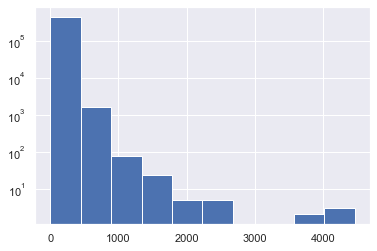

In [23]:
plt.hist(df1_by_users.Rating, log= True)
plt.show()

3. ¿Cómo es la distribución de las calificaciones?¿Pueden concluir algo de ese gráfico?

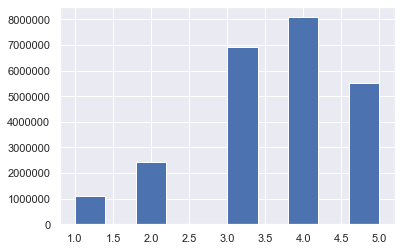

In [24]:
df1['Rating'].hist()
plt.show()

4. ¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

In [25]:
df1_by_movies = df1.groupby(['movie_id']).count()
df1_by_movies.head()

,User,Rating
movie_id,,
1,547,547
2,145,145
3,2012,2012
4,142,142
5,1140,1140


In [26]:
idx_max = df1_by_movies['User'].idxmax()
print(df_title.loc[idx_max].Name)

Pirates of the Caribbean: The Curse of the Black Pearl


In [27]:
# Pelicula con menos calificaciones
idx_min = df1_by_movies['User'].idxmin()
print(df_title.loc[idx_min].Name)

Bram Stoker's: To Die For


### Extra

Ordenamos las películas por popularidad y le ponemos el nombre

In [28]:
df1_by_movies = df1.groupby(['movie_id']).count()
df1_by_movies.sort_values('User', ascending = False, inplace = True)
df1_by_movies['Vistos'] = df1_by_movies['User']
df1_by_movies.drop(columns = ['User','Rating'], inplace = True)
df1_by_movies.head(10)

,Vistos
movie_id,
1905,193941
2152,162597
3860,160454
4432,156183
571,154832
3938,153996
4306,151292
2452,149866
1962,145519


In [29]:
df_title.head(3)

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character


In [30]:
df1_by_movies['Titulo'] = df_title.loc[df1_by_movies.index].Name

In [31]:
df1_by_movies.head()

,Vistos,Titulo
movie_id,,
1905,193941,Pirates of the Caribbean: The Curse of the Bla...
2152,162597,What Women Want
3860,160454,Bruce Almighty
4432,156183,The Italian Job
571,154832,American Beauty


### Opcional: filtrar películas con pocos ratings

Primero, veamos cómo es la distribución de `Vistos`.

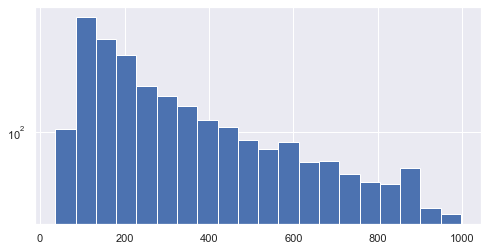

In [32]:
plt.figure(figsize = (8,4))
# df1_by_movies.Vistos.hist(log = True, bins = 50)
df1_by_movies.Vistos[df1_by_movies.Vistos<1000].hist(log = True, bins = 20)
plt.show()

Ahora vamos a elegir un umbral y descartar aquellas películas que tengan menos vistos que ese umbral. Primero, creamos un arreglo con los movies_ids de las películas que queremos descartar.

In [33]:
umbral = 1000
mascara_pocos_vistos = df1_by_movies.Vistos<umbral

In [34]:
peliculas_pocos_vistos = mascara_pocos_vistos[mascara_pocos_vistos].index.values
print(len(peliculas_pocos_vistos), peliculas_pocos_vistos)

2757 [1817  806 3486 ... 3656 4338 4362]


Ahora, tiramos de `df1` aquellas calificaciones que correspondan a las películas que queremos descartar.

In [35]:
mascara_descartables = df1.movie_id.isin(peliculas_pocos_vistos)
mascara_descartables

1           True
2           True
3           True
4           True
5           True
            ... 
24058258    True
24058259    True
24058260    True
24058261    True
24058262    True
Name: movie_id, Length: 24053764, dtype: bool

In [36]:
print(df1.shape)
df1 = df1[~mascara_descartables]
print(df1.shape)

(24053764, 3)
(23163063, 3)


## 3. Entrenamiento

Para entrenar el sistema de recomendación vamos a usar la biblioteca Surprise. Recomendamos tener abierta la [documentación](https://surprise.readthedocs.io/en/stable/getting_started.html) a medida que van a través de este notebook.

### 3.1 Dataset y Train/test split

Primero, llevamos el dataset al formato que le gusta a la biblioteca. ¿En qué orden tienen que estar los atributos?. Investigar qué hace la clase `Reader` y cuáles son sus parámetros.

In [37]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [38]:
reader = Reader()

Luego, creamos el `Dataset` de Surprise usando `Dataset.load_from_df`

In [39]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df1[['User', 'movie_id', 'Rating']][:N_filas], reader)

¿Cómo les parece que es mejor hacer el split?¿Dejando películas en test, usuarios o combinaciones?

In [40]:
trainset, testset = train_test_split(data, test_size=.25)

### 3.2 Entrenamiento

Vamos a entrenar un algoritmo SVD. Explorar sus parámetros y su funcionamiento.

In [41]:
from surprise import SVD
algo = SVD()

Entrenamos sobre el `trainset`

In [42]:
algo.fit(trainset)

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

In [43]:
predictions = algo.test(testset)

Explorar las característica de `predictions` y alguno de sus elementos

In [44]:
predictions[1]

Prediction(uid=1944937, iid=8, r_ui=3.0, est=3.259807227935511, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y una película en particular, usamos la función `predict`

In [45]:
algo.predict(1328945,28)

Prediction(uid=1328945, iid=28, r_ui=None, est=3.806463201597282, details={'was_impossible': False})

Exploremos un usuario, veamos cuáles películas le gustaron y cuáles les recomienda el sistema.

Películas que le gustaron

In [46]:
usuario = 1539350
rating = 4   # le pedimos peliculas a las que haya puesto 4 o 5 estrellas
df_user = df1[(df1['User'] == usuario) & (df1['Rating'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['Name'] = df_title['Name'].loc[df_user.movie_id].values
df_user

,User,Rating,movie_id,Name
0,1539350,4,111,Duplex (Widescreen)
1,1539350,4,175,Reservoir Dogs
2,1539350,4,197,Taking Lives
3,1539350,5,269,Parenthood
4,1539350,5,270,Sex and the City: Season 4
5,1539350,4,367,Spun
6,1539350,5,406,Hostage
7,1539350,4,457,Kill Bill: Vol. 2
8,1539350,4,692,The Hand that Rocks the Cradle
9,1539350,4,758,Mean Girls


Creamos donde vamos a guardar las recomendaciones

In [47]:
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


Sacamos del dataframe todas las películas que ya sabemos que vio

In [48]:
usuario_vistas = df1[df1['User'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(97, 3)


,User,Rating,movie_id
219903,1539350,3,33
409828,1539350,4,111
445333,1539350,3,127
664274,1539350,4,175
894915,1539350,4,197


In [49]:
if True: # Sacamos las que filtramos (si filtramos)
    recomendaciones_usuario.drop(peliculas_pocos_vistos, inplace = True)

In [50]:
recomendaciones_usuario.drop(usuario_vistas.movie_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,Movie_Id,Name
0,3,Character
1,5,The Rise and Fall of ECW
2,6,Sick
3,8,What the #$*! Do We Know!?
4,16,Screamers


Y hacemos las recomendaciones

In [51]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['Movie_Id'].apply(lambda x: algo.predict(usuario, x).est)

In [52]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

      Movie_Id                                           Name  Estimate_Score
8           25  Inspector Morse 31: Death Is Now My Neighbour        4.023479
1            5                       The Rise and Fall of ECW        3.991743
6           18                               Immortal Beloved        3.816744
10          28                                Lilo and Stitch        3.806463
11          30                         Something's Gotta Give        3.708733
0            3                                      Character        3.707413
1102      3054                                 I'm Not Scared        3.551613
1101      3047                        The Fabulous Baker Boys        3.551613
1094      3023                                       Upstairs        3.551613
1100      3046              The Simpsons: Treehouse of Horror        3.551613


### 3.3 Evaluación

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a las películas. Para eso, buscar en la documentación cómo se hace.

In [53]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.0423


1.0423305640755443

### 3.4 Optimización de parámetros

**Ejercicio**: hacer un gráfico del desempeño del modelo en función del número de factores del `SVD`

In [ ]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0422  1.0433  1.0329  1.0395  0.0046  
Fit time          1.75    2.04    2.46    2.08    0.29    
Test time         0.42    0.40    0.50    0.44    0.05    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0410  1.0400  1.0383  1.0398  0.0011  
Fit time          1.89    2.81    2.01    2.24    0.41    
Test time         0.52    0.39    0.39    0.43    0.06    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0376  1.0445  1.0401  1.0407  0.0028  
Fit time          2.77    1.96    3.01    2.58    0.45    
Test time         0.40    0.51    0.48    0.46    0.05    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0396  1.0

In [ ]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

**Ejercicio**: recordar que, cuando entrenamos un `SVD`, estamos usando descenso por gradiente para minimizar una función de costo. Usar `GridSearchCV` para buscar valores óptimos para los siguientes parámetros (tres por parámetros, utilizar los valores default de referencia): `n_factors`, `n_epochs`, `lr_all` y `reg_all`. Estudiar qué representa cada uno de ellos mientras esperan. Tomarse un café.

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [ ]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

## 4. Agrandando el Dataset

Ahora vamos a sumar al dataset el resto de las calificaciones que no usamos.

Como corremos el riesgo de que se nos llene la memoria RAM, vamos a hacerlo de a poco y con cuidado. Arrancamos agregando las calificaciones que hay en `combined_data_2.txt`.

0. Reiniciar el Kernel
1. Abrir el archivo `combined_data_2.txt` con la función `load_data`.
2. Agregar una columna con el movie_id al que corresponde las calificaciones. Si se animan, pueden crear una función que realice este paso.
3. Opcional: filtrar películas con pocas calificaciones
4. Abrir el archivo donde ya está procesado `combined_data_1.txt`. 
5. Agregar al final las nuevas calificaciones y guardarlo en un nuevo archivo.


Una vez que estén contentos con el procedimientos, repetir los pasos anteriores para los archivos faltantes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [2]:
### 1

def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    
    # A veces forzar un tipo de dato hace que se ahorre mucho lugar en memoria.
    df['Rating'] = df['Rating']#.astype(float) 
    return df


df2 = load_data('../DataSets/recomendacion/combined_data_2.txt')
print(df2.shape)

(26982302, 2)


In [3]:
### 2.
movies_ids_df2 = df2.User[df2.Rating.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

['4500:' '4501:' '4502:' ... '9208:' '9209:' '9210:']
4711
[4500 4501 4502 ... 9208 9209 9210]


In [4]:
df2_nan = pd.DataFrame(pd.isnull(df2.Rating))
df2_nan = df2_nan[df2_nan['Rating'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

[       0      259      855 ... 26961403 26980373 26980497]


In [5]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])

In [6]:
cantidad_criticas = np.diff(idx_movies_ids)

In [7]:
cantidad_criticas

array([  259,   596,   105, ..., 18970,   124,  1805], dtype=int64)

In [8]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [9]:
df2['movie_id'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['User'] = df2['User'].astype(int)
df2['movie_id'] = df2['movie_id'].astype(np.int16)
df2['Rating'] = df2['Rating'].astype(np.int8)

gc.collect()

0

In [10]:
df2

,User,Rating,movie_id
1,2532865,4,4500
2,573364,3,4500
3,1696725,3,4500
4,1253431,3,4500
5,1265574,2,4500
...,...,...,...
26982297,2420260,1,9210
26982298,761176,3,9210
26982299,459277,3,9210
26982300,2407365,4,9210


In [11]:
### 4.

df1 = pd.read_csv('../DataSets/recomendacion/combined_data_1_con_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [12]:
### 5.
df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

(51031355, 3)


Chequeamos que estén todas las películas:

In [13]:
peliculas_presentes = df.movie_id.unique()
peliculas_presentes

array([   1,    2,    3, ..., 9208, 9209, 9210], dtype=int64)

In [14]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

0


Y guardamos

In [15]:
if True:
    df.to_csv('../DataSets/recomendacion/combined_data_1y2_con_movie_id.csv', index= False)